# Anomaliedetectie a.d.h.v. Numentas HTM algoritme op de machine temperatuur tijdreeks

In [1]:
import time
import csv
import datetime
import os
import numpy as np
import random
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from htm.bindings.sdr import SDR, Metrics
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.encoders.date import DateEncoder
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood
from htm.bindings.algorithms import Predictor

### HTM is een recurrent neuraal netwerk, hierbij moeten vooraf parameters ingesteld worden

In [4]:
parameters = {
 'enc': {
      "value" :
         {'resolution': 0.88, 'size': 700, 'sparsity': 0.02},
      "time": 
         {'dayOfWeek': (7, 1), 'timeOfDay': (4, 1), 'weekend': 2}
 },
 'predictor': {'sdrc_alpha': 0.1},
 'sp': {'boostStrength': 3.0,
        'columnCount': 1638,
        'localAreaDensity': 0.04395604395604396,
        'potentialPct': 0.85,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'synPermInactiveDec': 0.006},
 'tm': {'activationThreshold': 17,
        'cellsPerColumn': 13,
        'initialPerm': 0.21,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'minThreshold': 10,
        'newSynapseCount': 32,
        'permanenceDec': 0.1,
        'permanenceInc': 0.1},
 'anomaly': {
   'likelihood': {
        'probationaryPct': 0.1,
        'reestimationPeriod': 100
   }
 }
}

_DIR = os.path.dirname(os.path.abspath('htm.core'))
_INPUT_FILE_PATH = os.path.join(_DIR, "machine_temperature_system_failure.csv")

### Uitvoeren van anomaliedetectie en tijdsmeting
De tijd wordt enkel gemeten voor het effectief voorspellen, aangezien er verwacht wordt dat het neural netwerk al gebouwd is.

In [5]:
def htm_find_anomalies(parameters=parameters, verbose=True):
  if verbose:
    import pprint
    print("Parameters:")
    pprint.pprint(parameters, indent=4)
    print("")

  # Read the input file.
  records = []
  with open(_INPUT_FILE_PATH, "r") as fin:
    reader = csv.reader(fin)
    headers = next(reader)
    for record in reader:
      records.append(record)

  # Make the Encoders.  These will convert input data into binary representations.
  dateEncoder = DateEncoder(timeOfDay= parameters["enc"]["time"]["timeOfDay"], 
                             weekend  = parameters["enc"]["time"]["weekend"],
                             dayOfWeek = parameters["enc"]["time"]["dayOfWeek"]) 
  
  scalarEncoderParams            = RDSE_Parameters()
  scalarEncoderParams.size       = parameters["enc"]["value"]["size"]
  scalarEncoderParams.sparsity   = parameters["enc"]["value"]["sparsity"]
  scalarEncoderParams.resolution = parameters["enc"]["value"]["resolution"]
  scalarEncoder = RDSE( scalarEncoderParams )
  encodingWidth = (dateEncoder.size + scalarEncoder.size)
  enc_info = Metrics( [encodingWidth], 999999999 )

  # Make the HTM.  SpatialPooler & TemporalMemory & associated tools.
  spParams = parameters["sp"]
  sp = SpatialPooler(
    inputDimensions            = (encodingWidth,),
    columnDimensions           = (spParams["columnCount"],),
    potentialPct               = spParams["potentialPct"],
    potentialRadius            = encodingWidth,
    globalInhibition           = True,
    localAreaDensity           = spParams["localAreaDensity"],
    synPermInactiveDec         = spParams["synPermInactiveDec"],
    synPermActiveInc           = spParams["synPermActiveInc"],
    synPermConnected           = spParams["synPermConnected"],
    boostStrength              = spParams["boostStrength"],
    wrapAround                 = True
  )
  sp_info = Metrics( sp.getColumnDimensions(), 999999999 )

  tmParams = parameters["tm"]
  tm = TemporalMemory(
    columnDimensions          = (spParams["columnCount"],),
    cellsPerColumn            = tmParams["cellsPerColumn"],
    activationThreshold       = tmParams["activationThreshold"],
    initialPermanence         = tmParams["initialPerm"],
    connectedPermanence       = spParams["synPermConnected"],
    minThreshold              = tmParams["minThreshold"],
    maxNewSynapseCount        = tmParams["newSynapseCount"],
    permanenceIncrement       = tmParams["permanenceInc"],
    permanenceDecrement       = tmParams["permanenceDec"],
    predictedSegmentDecrement = 0.0,
    maxSegmentsPerCell        = tmParams["maxSegmentsPerCell"],
    maxSynapsesPerSegment     = tmParams["maxSynapsesPerSegment"]
  )
  tm_info = Metrics( [tm.numberOfCells()], 999999999 )

  # setup likelihood
  anParams = parameters["anomaly"]["likelihood"]
  probationaryPeriod = int(math.floor(float(anParams["probationaryPct"])*len(records)))
  learningPeriod     = int(math.floor(probationaryPeriod / 2.0))
  anomaly_history = AnomalyLikelihood(learningPeriod= learningPeriod,
                                      estimationSamples= probationaryPeriod - learningPeriod,
                                      reestimationPeriod= anParams["reestimationPeriod"])

  predictor = Predictor( steps=[1, 5], alpha=parameters["predictor"]['sdrc_alpha'] )
  predictor_resolution = 1

  # Iterate through every datum in the dataset, record the inputs & outputs.
  inputs      = []
  anomaly     = []
  anomalyProb = []
  predictions = {1: [], 5: []}

  start_time = time.time()

  for count, record in enumerate(records):

    # Convert date string into Python date object.
    # original: dateString = datetime.datetime.strptime(record[0], "%m/%d/%y %H:%M")
    dateString = datetime.datetime.strptime(record[0], "%Y-%m-%d %H:%M:%S")
    # Convert data value string into float.
    consumption = float(record[1])
    inputs.append( consumption )

    # Call the encoders to create bit representations for each value.  These are SDR objects.
    dateBits        = dateEncoder.encode(dateString)
    consumptionBits = scalarEncoder.encode(consumption)

    # Concatenate all these encodings into one large encoding for Spatial Pooling.
    encoding = SDR( encodingWidth ).concatenate([consumptionBits, dateBits])
    enc_info.addData( encoding )

    # Create an SDR to represent active columns, This will be populated by the
    # compute method below. It must have the same dimensions as the Spatial Pooler.
    activeColumns = SDR( sp.getColumnDimensions() )

    # Execute Spatial Pooling algorithm over input space.
    sp.compute(encoding, True, activeColumns)
    sp_info.addData( activeColumns )

    # Execute Temporal Memory algorithm over active mini-columns.
    tm.compute(activeColumns, learn=True)
    tm_info.addData( tm.getActiveCells().flatten() )

    # Predict what will happen, and then train the predictor based on what just happened.
    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1, 5):
      if pdf[n]:
        predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
      else:
        predictions[n].append(float('nan'))

    anomalyLikelihood = anomaly_history.anomalyProbability( consumption, tm.anomaly )
    anomaly.append( tm.anomaly )
    anomalyProb.append( anomalyLikelihood )

    predictor.learn(count, tm.getActiveCells(), int(consumption / predictor_resolution))

  execution_time = time.time() - start_time
    
  # Print information & statistics about the state of the HTM.
  print("Encoded Input", enc_info)
  print("")
  print("Spatial Pooler Mini-Columns", sp_info)
  print(str(sp))
  print("")
  print("Temporal Memory Cells", tm_info)
  print(str(tm))
  print("")

  # Shift the predictions so that they are aligned with the input they predict.
  for n_steps, pred_list in predictions.items():
    for x in range(n_steps):
        pred_list.insert(0, float('nan'))
        pred_list.pop()
        
  return inputs, predictions, anomaly, execution_time
        

htm_output = htm_find_anomalies()

Parameters:
{   'anomaly': {   'likelihood': {   'probationaryPct': 0.1,
                                     'reestimationPeriod': 100}},
    'enc': {   'time': {'dayOfWeek': (7, 1), 'timeOfDay': (4, 1), 'weekend': 2},
               'value': {'resolution': 0.88, 'size': 700, 'sparsity': 0.02}},
    'predictor': {'sdrc_alpha': 0.1},
    'sp': {   'boostStrength': 3.0,
              'columnCount': 1638,
              'localAreaDensity': 0.04395604395604396,
              'potentialPct': 0.85,
              'synPermActiveInc': 0.04,
              'synPermConnected': 0.13999999999999999,
              'synPermInactiveDec': 0.006},
    'tm': {   'activationThreshold': 17,
              'cellsPerColumn': 13,
              'initialPerm': 0.21,
              'maxSegmentsPerCell': 128,
              'maxSynapsesPerSegment': 64,
              'minThreshold': 10,
              'newSynapseCount': 32,
              'permanenceDec': 0.1,
              'permanenceInc': 0.1}}

Encoded Input SDR( 849

### Plotten van voorspelde waarden en anomaliekansen

HTM executed in: 42.79255270957947 seconds


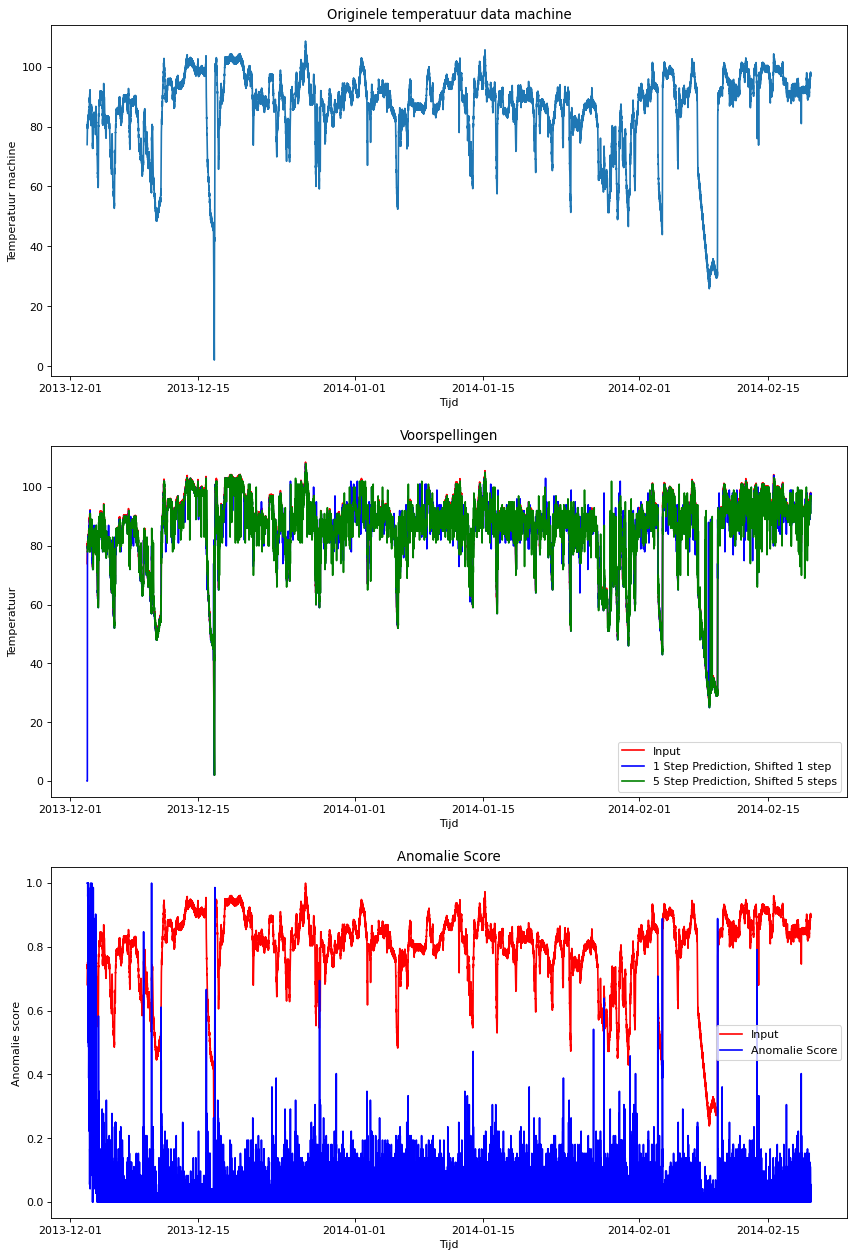

In [6]:
inputs = htm_output[0]
predictions = htm_output[1]
anomalies = htm_output[2]
execution_time = htm_output[3]

print(f'HTM executed in: {execution_time} seconds')

timestamps = pd.read_csv("machine_temperature_system_failure.csv")['timestamp']
timestamps = pd.to_datetime(timestamps)
timestamps = timestamps.to_numpy()


plt.figure(figsize=(13, 20), dpi= 79, facecolor='w', edgecolor='k')

plt.subplot(3,1,1)
plt.title("Originele temperatuur data machine")
plt.xlabel("Tijd")
plt.ylabel("Temperatuur machine")
plt.plot(timestamps, inputs)

plt.subplot(3,1,2)
plt.title("Voorspellingen")
plt.xlabel("Tijd")
plt.ylabel("Temperatuur")
plt.plot(timestamps, inputs, 'red',
         timestamps, predictions[1], 'blue',
         timestamps, predictions[5], 'green',)
plt.legend(labels=('Input', '1 Step Prediction, Shifted 1 step', '5 Step Prediction, Shifted 5 steps'))

plt.subplot(3,1,3)
plt.title("Anomalie Score")
plt.xlabel("Tijd")
plt.ylabel("Anomalie score")
inputs = np.array(inputs) / max(inputs)
plt.plot(timestamps, inputs, 'red',
         timestamps, anomalies, 'blue',)
plt.legend(labels=('Input', 'Anomalie Score'))

plt.show()

In [7]:
temperatuur_data = pd.read_csv("./machine_temperature_system_failure.csv")
temperatuur_data_anomalies = temperatuur_data.copy(deep=True)
temperatuur_data_anomalies['Likelihood'] = anomalies

In [8]:
# eerste 15% van data - grotendeels incorrect wegens te weinig data om te leren
n_rows = math.floor(len(temperatuur_data_anomalies) * 0.85)
temperatuur_data_anomalies = temperatuur_data_anomalies.tail(n_rows)

In [9]:
# anomalie als likelihood boven 70% ligt
temperatuur_data_anomalies = temperatuur_data_anomalies[temperatuur_data_anomalies['Likelihood'] > 0.70]

In [10]:
print(f'{len(temperatuur_data_anomalies)} anomalies detected')
print('')
print(temperatuur_data_anomalies)

13 anomalies detected

                 timestamp      value  Likelihood
4001   2013-12-16 18:40:00  60.535948    0.805556
4002   2013-12-16 18:45:00  72.366769    0.847222
4003   2013-12-16 18:50:00  81.633690    0.944444
4004   2013-12-16 18:55:00  87.730379    0.763889
4005   2013-12-16 19:00:00  90.420824    0.986111
17901  2014-02-03 00:00:00  80.632450    0.708333
18044  2014-02-03 11:55:00  60.111973    0.888889
18045  2014-02-03 12:00:00  68.160566    0.708333
19772  2014-02-09 11:55:00  43.971303    0.819444
19775  2014-02-09 12:10:00  69.604159    0.888889
19776  2014-02-09 12:15:00  74.699589    0.888889
19778  2014-02-09 12:25:00  81.764577    0.736111
21012  2014-02-13 19:15:00  85.907177    0.791667


### Plotten van de data met aanduiding van de gedetecteerde anomalieën

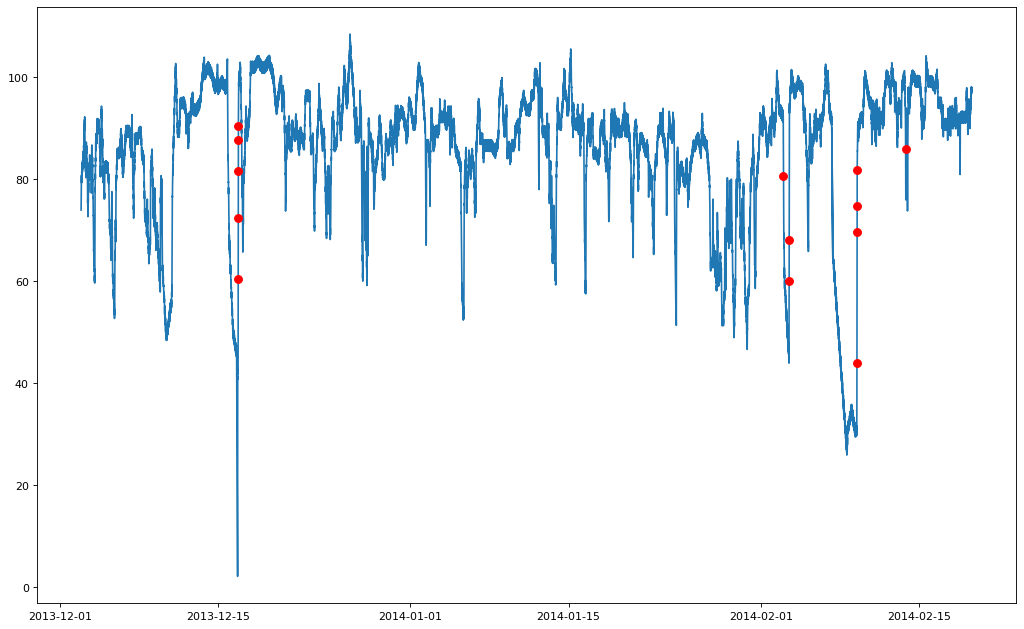

In [11]:
# Plotten van anomalieën op grafiek
temperatuur_timestamp_index = temperatuur_data.copy(deep=True)
temperatuur_timestamp_index['timestamp'] = pd.to_datetime(temperatuur_timestamp_index['timestamp'])
temperatuur_timestamp_index = temperatuur_timestamp_index.set_index('timestamp')

temperatuur_data_anomalies['timestamp'] = pd.to_datetime(temperatuur_data_anomalies['timestamp'])

plt.figure(figsize=(16, 10), dpi= 79, facecolor='w', edgecolor='k')
plt.plot(temperatuur_timestamp_index.index, temperatuur_timestamp_index['value'], zorder=1)
plt.scatter(temperatuur_data_anomalies['timestamp'], temperatuur_data_anomalies['value'], c='Red', s=50, zorder=2)
plt.show()